# Apply learnings to Titanic

In [1]:
import os
from pathlib import Path

iskaggle = os.environ.get('KAGGLE_KERNEL_RUN_TYPE', '')
if iskaggle: 
    path = Path('../input/titanic')
else:
    path = Path('titanic')
    if not path.exists():
        import zipfile,kaggle
        kaggle.api.competition_download_cli(str(path))
        zipfile.ZipFile(f'{path}.zip').extractall(path)

In [2]:
import numpy as np, pandas as pd
import omdml
from collections import Counter
import warnings

warnings.filterwarnings('ignore')
pd.options.display.max_columns = None

In [3]:
df_train = pd.read_csv(path/'train.csv')
df_train = df_train.sample(frac=1, random_state=42)
print(df_train.shape)
df_train.head()

(891, 12)


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
709,710,1,3,"Moubarek, Master. Halim Gonios (""William George"")",male,NaN,1,1,2661,15.2458,NaN,C
439,440,0,2,"Kvillner, Mr. Johan Henrik Johannesson",male,31.0,0,0,C.A. 18723,10.5000,NaN,S
840,841,0,3,"Alhomaki, Mr. Ilmari Rudolf",male,20.0,0,0,SOTON/O2 3101287,7.9250,NaN,S
720,721,1,2,"Harper, Miss. Annie Jessie ""Nina""",female,6.0,0,1,248727,33.0000,NaN,S
39,40,1,3,"Nicola-Yarred, Miss. Jamila",female,14.0,1,0,2651,11.2417,NaN,C


### Preprocessing 

In [4]:
df_train = pd.read_csv(path/'train.csv')
df_train = df_train.sample(frac=1, random_state=42)
df_train['Pclass'].replace((1,2,3), ("1", "2", "3"), inplace=True)
df_train.drop(['PassengerId', 'Name', 'Ticket', 'Cabin'], axis=1, inplace=True)
X_train = df_train.iloc[:,1:]
y_train = df_train.iloc[:,0]

X_test = pd.read_csv(path/'test.csv')
X_test['Pclass'].replace((1,2,3), ("1", "2", "3"), inplace=True)
test_passengerids = X_test['PassengerId']
X_test.drop(['PassengerId', 'Name', 'Ticket', 'Cabin'], axis=1, inplace=True)

display(X_train.head())
X_test.head()

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
709,3,male,NaN,1,1,15.2458,C
439,2,male,31.0,0,0,10.5000,S
840,3,male,20.0,0,0,7.9250,S
720,2,female,6.0,0,1,33.0000,S
39,3,female,14.0,1,0,11.2417,C


,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,3,male,34.5,0,0,7.8292,Q
1,3,female,47.0,1,0,7.0000,S
2,2,male,62.0,0,0,9.6875,Q
3,3,male,27.0,0,0,8.6625,S
4,3,female,22.0,1,1,12.2875,S


In [5]:
# impute missing values
numeric = ['Age', 'SibSp', 'Parch', 'Fare']
categorical = ['Pclass', 'Sex', 'Embarked']

numeric_median = X_train[numeric].median()
categorical_mode = X_train[categorical].mode()

print(numeric_median)
print(categorical_mode.T)

Age      28.0000
SibSp     0.0000
Parch     0.0000
Fare     14.4542
dtype: float64
             0
Pclass       3
Sex       male
Embarked     S


In [6]:
temp = X_train.isna().sum()
temp[temp>0]

Age         177
Embarked      2
dtype: int64

In [7]:
X_train['Age'] = X_train['Age'].fillna(X_train.groupby(['Pclass', 'Sex'])['Age'].transform('median'))

In [8]:
X_test['Age'] = X_test['Age'].fillna(X_train.groupby(['Pclass', 'Sex'])['Age'].transform('median'))

In [9]:
X_train.fillna(value=numeric_median, inplace=True)
X_train.fillna(value=categorical_mode.T.squeeze(), inplace=True)

X_test.fillna(value=numeric_median, inplace=True)
X_test.fillna(value=categorical_mode.T.squeeze(), inplace=True)

print('Any missing values?')
print('===================')
print(X_train.isna().sum())
print(X_test.isna().sum())

Any missing values?
Pclass      0
Sex         0
Age         0
SibSp       0
Parch       0
Fare        0
Embarked    0
dtype: int64
Pclass      0
Sex         0
Age         0
SibSp       0
Parch       0
Fare        0
Embarked    0
dtype: int64


In [10]:
# convert categoricals to numericals
X_train = pd.get_dummies(X_train)
display(X_train.head())
X_test = pd.get_dummies(X_test)
display(X_test.head())

,Age,SibSp,Parch,Fare,Pclass_1,Pclass_2,Pclass_3,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S
709,25.0,1,1,15.2458,0,0,1,0,1,1,0,0
439,31.0,0,0,10.5000,0,1,0,0,1,0,0,1
840,20.0,0,0,7.9250,0,0,1,0,1,0,0,1
720,6.0,0,1,33.0000,0,1,0,1,0,0,0,1
39,14.0,1,0,11.2417,0,0,1,1,0,1,0,0


,Age,SibSp,Parch,Fare,Pclass_1,Pclass_2,Pclass_3,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S
0,34.5,0,0,7.8292,0,0,1,0,1,0,1,0
1,47.0,1,0,7.0000,0,0,1,1,0,0,0,1
2,62.0,0,0,9.6875,0,1,0,0,1,0,1,0
3,27.0,0,0,8.6625,0,0,1,0,1,0,0,1
4,22.0,1,1,12.2875,0,0,1,1,0,0,0,1


### target encoding

In [11]:
from category_encoders.target_encoder import TargetEncoder
encoder = TargetEncoder(return_df=True)
X_train = encoder.fit_transform(X_train, y_train)
X_test = encoder.transform(X_test)
display(X_train.head())
X_test.head()

,Age,SibSp,Parch,Fare,Pclass_1,Pclass_2,Pclass_3,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S
709,25.0,1,1,15.2458,0,0,1,0,1,1,0,0
439,31.0,0,0,10.5000,0,1,0,0,1,0,0,1
840,20.0,0,0,7.9250,0,0,1,0,1,0,0,1
720,6.0,0,1,33.0000,0,1,0,1,0,0,0,1
39,14.0,1,0,11.2417,0,0,1,1,0,1,0,0


,Age,SibSp,Parch,Fare,Pclass_1,Pclass_2,Pclass_3,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S
0,34.5,0,0,7.8292,0,0,1,0,1,0,1,0
1,47.0,1,0,7.0000,0,0,1,1,0,0,0,1
2,62.0,0,0,9.6875,0,1,0,0,1,0,1,0
3,27.0,0,0,8.6625,0,0,1,0,1,0,0,1
4,22.0,1,1,12.2875,0,0,1,1,0,0,0,1


### Compare X_train and X_test distributions

In [12]:
print(X_train.columns)
print(X_test.columns)

Index(['Age', 'SibSp', 'Parch', 'Fare', 'Pclass_1', 'Pclass_2', 'Pclass_3',
       'Sex_female', 'Sex_male', 'Embarked_C', 'Embarked_Q', 'Embarked_S'],
      dtype='object')
Index(['Age', 'SibSp', 'Parch', 'Fare', 'Pclass_1', 'Pclass_2', 'Pclass_3',
       'Sex_female', 'Sex_male', 'Embarked_C', 'Embarked_Q', 'Embarked_S'],
      dtype='object')


In [13]:
import sweetviz as sv

# my_report = sv.analyze(df_train, target_feat = 'Survived')
my_report = sv.compare_intra(X_train, X_test, X_train.columns.tolist())
my_report.show_html() 

ValueError: compare_intra() expects source_df and condition_series to be the same length

### Base model & finetuned models

In [14]:
from sklearn.metrics import accuracy_score
from xgboost import XGBClassifier, XGBRFClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, StackingClassifier
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, StratifiedKFold, RepeatedStratifiedKFold, cross_val_score

def y_pred(model):
    model.fit(X_train, y_train)
    y_pred_train = model.predict(X_train)
    score = accuracy_score(y_pred_train, y_train)
    print(score)
    y_pred = model.predict(X_test)
    return y_pred

### Learn about `imblearn` Python library for imbalanced datasets 
[https://imbalanced-learn.org](https://imbalanced-learn.org/stable/user_guide.html#user-guide)  

Most classification algorithms will only perform optimally when the number of samples of each class is roughly the same. Highly skewed datasets, where the minority is heavily outnumbered by one or more classes, have proven to be a challenge while at the same time becoming more and more common.
One way of addressing this issue is by re-sampling the dataset as to offset this imbalance with the hope of arriving at a more robust and fair decision boundary than you would otherwise.

#### Naive random over-sampling, SMOTE, and others... 

One way to fight this issue is to generate new samples in the classes which are under-represented. The most naive strategy is to generate new samples by randomly sampling with replacement the current available samples. The RandomOverSampler offers such scheme:

In [15]:
from imblearn.over_sampling import RandomOverSampler, SMOTE
from collections import Counter

ros = RandomOverSampler(random_state=0)
X_resampled, y_resampled = ros.fit_resample(X_train, y_train)
# X_resampled, y_resampled = SMOTE().fit_resample(X_train, y_train)

print(sorted(Counter(y_resampled).items()))

[(0, 549), (1, 549)]


In [16]:
import matplotlib.pyplot as plt 
import seaborn as sns

def plot_confusion_matrix(data, labels, output_filename=None):
    """Plot confusion matrix using heatmap.
 
    Args:
        data (list of list): List of lists with confusion matrix data.
        labels (list): Labels which will be plotted across x and y axis.
        output_filename (str): Path to output file.
 
    """
    sns.set(color_codes=True)
    plt.figure(1, figsize=(9, 6))
 
    plt.title("Confusion Matrix")
 
    sns.set(font_scale=1.4)
    ax = sns.heatmap(data, annot=True, cmap="YlGnBu", cbar_kws={'label': 'Scale'}, fmt='g')
 
    ax.set_xticklabels(labels)
    ax.set_yticklabels(labels)
 
    ax.set(ylabel="True Label", xlabel="Predicted Label")
 
    # plt.savefig(output_filename, bbox_inches='tight', dpi=300)
    plt.show()
    plt.close()

In [17]:
def create_confusion_matrix(model, X, y, labels):
    from sklearn.metrics import ConfusionMatrixDisplay
    # normalize confusion matrix
    np.set_printoptions(precision=2)

    # Plot non-normalized confusion matrix
    titles_options = [
        ("Confusion matrix, without normalization", None),
        ("Normalized confusion matrix", "true"),
    ]
    for title, normalize in titles_options:
        disp = ConfusionMatrixDisplay.from_estimator(
            model,
            X,
            y,
            display_labels=labels,
            cmap=plt.cm.Blues,
            normalize=normalize,
        )
        disp.ax_.set_title(title)

        plt.grid(False)
        print(title)
        print(disp.confusion_matrix)

    plt.show()

[medium: Precision-Recall Curves](https://medium.com/@douglaspsteen/precision-recall-curves-d32e5b290248)

In [18]:
def calc_precision_recall(y_true, y_pred):
    
    # Convert predictions to series with index matching y_true
    y_pred = pd.Series(y_pred, index=y_true.index)
    
    # Instantiate counters
    TP = 0
    FP = 0
    FN = 0

    # Determine whether each prediction is TP, FP, TN, or FN
    for i in y_true.index: 
        if y_true[i]==y_pred[i]==1:
           TP += 1
        if y_pred[i]==1 and y_true[i]!=y_pred[i]:
           FP += 1
        if y_pred[i]==0 and y_true[i]!=y_pred[i]:
           FN += 1
    
    # Calculate true positive rate and false positive rate
    # Use try-except statements to avoid problem of dividing by 0
    try:
        precision = TP / (TP + FP)
    except:
        precision = 1
    
    try:
        recall = TP / (TP + FN)
    except:
        recall = 1

    return precision, recall

In [19]:
import catboost
print(catboost.__version__)

1.0.6


[Area Under Precision Recall Curve (AUPRC)](https://glassboxmedicine.com/2019/03/02/measuring-performance-auprc/)

In [20]:
from sklearn.metrics import precision_recall_curve, average_precision_score, roc_auc_score, roc_curve, auc
from sklearn.metrics import PrecisionRecallDisplay
from xgboost import XGBClassifier

xgb = XGBClassifier(verbosity=0, random_state=42)
xgb.fit(X_resampled, y_resampled)
probs = xgb.predict_proba(X_resampled)
probs = xgb.predict_proba(X_resampled)
df_probs = pd.DataFrame(probs, columns=['No', 'Yes'])
auprc = average_precision_score(y_resampled, df_probs['Yes'])

# Containers for true positive / false positive rates
precision_scores = []
recall_scores = []

thresholds = np.linspace(0, 1, num=10)

for i in thresholds:
    df_probs[str(i.round(4))] = [1 if k >= i else 0 for k in df_probs['Yes']]
    precision, recall, threshold = precision_recall_curve(y_resampled, y_pred)
    precision, recall = calc_precision_recall(y_resampled, df_probs[str(i.round(4))])
    precision_scores.append(precision)
    recall_scores.append(recall)

#AUROC
fpr, tpr, thresholds = roc_curve(y_resampled, df_probs['Yes'], pos_label = 1) #positive class is 1; negative class is 0
auroc = auc(fpr, tpr)
print('auroc: {0:0.4f}'.format(auroc))
print('AUC ROC: {0:0.4f}'.format(roc_auc_score(y_resampled, xgb.predict_proba(X_resampled)[:, 1])))

# AUPRC baseline
ratio = np.round(len(y_resampled[y_resampled==1]) / len(y_resampled), 2)
title = 'Precision/Recall Curve (AUPRC baseline: ' + str(ratio.round(4)) + ')'

plt.plot(recall_scores, precision_scores)
plt.xlim(0.0, 1.05), plt.ylim(np.min(precision_scores)-0.05), 1.05, plt.xlabel('Recall'), plt.ylabel('Precision'), plt.title(title)
plt.text(0.3, 0.72, 'AUPRC: ' + str(auprc.round(4)), bbox=dict(facecolor='red', alpha=0.5));

df_probs.head(20)

TypeError: Expected sequence or array-like, got <class 'function'>

[0 1]


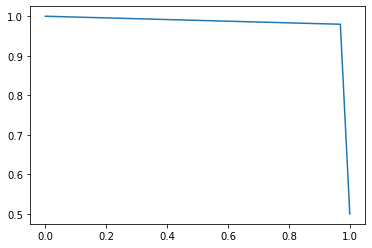

In [28]:
precision, recall, thresholds = precision_recall_curve(y_resampled, y_pred)
print(thresholds)
plt.plot(recall, precision);

In [29]:
roc_auc

0.9744990892531876

In [2]:
from sklearn.metrics import confusion_matrix, classification_report, precision_recall_curve, \
     roc_auc_score, accuracy_score, log_loss, plot_roc_curve, RocCurveDisplay, auc
from sklearn.model_selection import cross_val_predict

# baseline
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
xgb = XGBClassifier(booster='gbtree', random_state=42, verbosity=0)
scores = cross_val_score(xgb, X_resampled, y_resampled, cv=kfold)

print('Accuracy Scores: ', scores.round(4))
print('Mean Accuracy Score:', scores.mean().round(4))

xgb.fit(X_resampled, y_resampled)
y_pred = xgb.predict(X_resampled)
precision, recall, thresholds = precision_recall_curve(y_resampled, y_pred)
print('ROC AUC Score: ', roc_auc_score(y_true=y_resampled, y_score=y_pred).round(4))
print('ROC AUC Score (Prob): {0:0.4f}'.format(roc_auc_score(y_resampled, xgb.predict_proba(X_resampled)[:, 1])))
print('X-val predict:', cross_val_predict(xgb, X_resampled, y_resampled, cv=kfold))

fpr, tpr, thresholds = roc_curve(y_resampled, y_pred)
roc_auc = auc(fpr, tpr)
display = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc, estimator_name='example estimator')
display.plot()  

print('Accuracy: ', accuracy_score(y_true=y_resampled, y_pred=y_pred).round(4))
print('Log loss: ', log_loss(y_resampled, y_pred).round(4))

print(classification_report(y_true=y_resampled, y_pred=y_pred))

data = pd.DataFrame(confusion_matrix(y_resampled, y_pred))
# plot_confusion_matrix(data, ['Not Survived', 'Survived'])
# create_confusion_matrix(xgb, X_train, y_train, ['Not Survived', 'Survived'])

create_confusion_matrix(xgb, X_resampled, y_resampled, ['Not Survived', 'Survived'])
plot_roc_curve(xgb, X_resampled, y_resampled); 


NameError: name 'StratifiedKFold' is not defined

In [115]:
# What proportion of positive identifications was actually correct?
# Precision gives the percentage of correct predictions for each target class.
print('Precision 0: ', np.round((538 / (538+17)),2))   # TN / (TN + FN)
print('Precision 1: ', np.round((532 / (532+11)),2))   # TP / (TP + FP)   ***

# What proportion of actual positives was identified correctly?
# Recall gives you the percentage of positive cases that your predictions uncovered.
print('Recall 0: ', np.round((538 / (538+11)),2))   # TN / (TN + FP)
print('Recall 1: ', np.round((532 / (532+17)),2))   # TP / (TP + FN)   ***

Precision 0:  0.97
Precision 1:  0.98
Recall 0:  0.98
Recall 1:  0.97


Text(0, 0.5, 'Accuracy')

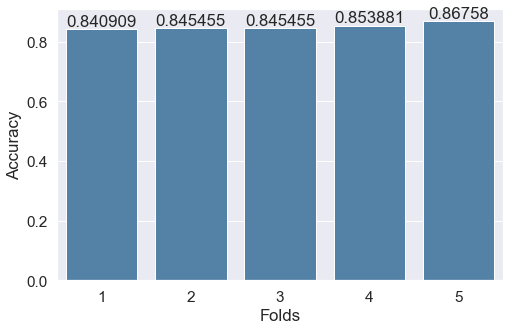

In [91]:
plt.figure(figsize=(8,5))
ax=sns.barplot(x=[1,2,3,4,5],y=scores, color='steelblue')
ax.bar_label(ax.containers[0])
ax.set_xlabel('Folds')
ax.set_ylabel('Accuracy')

Accuracy Scores:  [0.8268 0.8258 0.8202 0.8483 0.7865]
Mean Accuracy Score: 0.8215
ROC AUC Score:  0.9617
Accuracy:  0.9663
              precision    recall  f1-score   support

           0       0.96      0.98      0.97       549
           1       0.97      0.94      0.96       342

    accuracy                           0.97       891
   macro avg       0.97      0.96      0.96       891
weighted avg       0.97      0.97      0.97       891



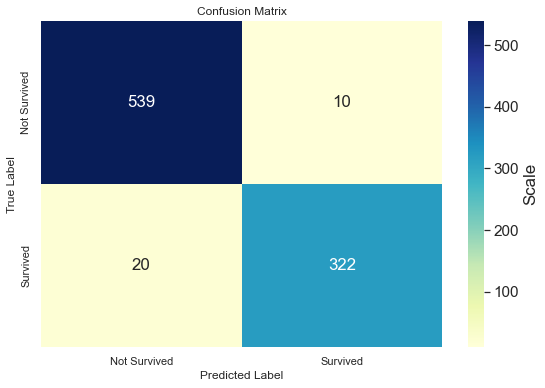

In [27]:
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, accuracy_score

# baseline
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
xgb = XGBClassifier(booster='gbtree', random_state=42, verbosity=0)
scores = cross_val_score(xgb, X_train, y_train, cv=kfold)

print('Accuracy Scores: ', scores.round(4))
print('Mean Accuracy Score:', scores.mean().round(4))

xgb.fit(X_train, y_train)
y_pred = xgb.predict(X_train)
print('ROC AUC Score: ', roc_auc_score(y_true=y_train, y_score=y_pred).round(4))
print('Accuracy: ', accuracy_score(y_true=y_train, y_pred=y_pred).round(4))

print(classification_report(y_true=y_train, y_pred=y_pred))

data = pd.DataFrame(confusion_matrix(y_train, y_pred))
plot_confusion_matrix(data, ['Not Survived', 'Survived'])

### Precision and Recall: A Tug of War  

To fully evaluate the effectiveness of a model, you must examine both **precision** and **recall**. Unfortunately, precision and recall are often in tension. That is, improving precision typically reduces recall and vice versa. Explore this notion by looking at the following figure, which shows 30 predictions made by an email classification model. Those to the right of the classification threshold are classified as "spam", while those to the left are classified as "not spam."  
  
resource: [developers.google.com](https://developers.google.com/machine-learning/crash-course/classification/precision-and-recall)

In [113]:
# What proportion of positive identifications was actually correct?
# Precision gives the percentage of correct predictions for each target class.
# In essence, the metric tells you how often you are correct when you predict a positive.
print('Precision 0: ', np.round((539 / (539+20)),2))   # TN / (TN + FN)
print('Precision 1: ', np.round((322 / (322+10)),2))   # TP / (TP + FP)   ***

# What proportion of actual positives was identified correctly?
# Recall gives you the percentage of positive cases that your predictions uncovered.
# 
print('Recall 0: ', np.round((539 / (539+10)),2))   # TN / (TN + FP)
print('Recall 1: ', np.round((322 / (322+20)),2))   # TP / (TP + FN)   ***

Precision 0:  0.96
Precision 1:  0.97
Recall 0:  0.98
Recall 1:  0.94


Confusion matrix, without normalization
[[539  10]
 [ 20 322]]
Normalized confusion matrix
[[0.98 0.02]
 [0.06 0.94]]


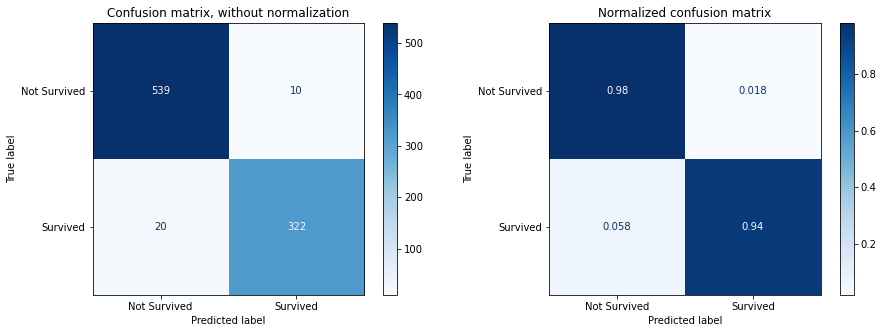

In [30]:
import omdml
xgb = XGBClassifier(booster='gbtree', random_state=42, verbosity=0)
xgb.fit(X_train, y_train)

omdml.create_confusion_matrix(xgb, X_train, y_train, ['Not Survived', 'Survived'])

In [20]:
# make predictions with various algorithms
y_pred_xgb = y_pred(XGBClassifier(booster='gbtree', learning_rate=0.01, n_estimators=200, max_depth=3, random_state=42))
y_pred_dart = y_pred(XGBClassifier(booster='dart', one_drop=1, random_state=42))
y_pred_gblinear = y_pred(XGBClassifier(booster='gblinear', random_state=42))
y_pred_forest = y_pred(XGBRFClassifier(random_state=42))
y_pred_logistic = y_pred(LogisticRegression(max_iter=1000, random_state=42))
y_pred_svm = y_pred(SVC(kernel= 'linear', random_state=42, C=0.1))
y_pred_knn = y_pred(KNeighborsClassifier(3))

# combine predictions
df_pred = pd.DataFrame(data= np.c_[y_pred_xgb, y_pred_dart, y_pred_gblinear, y_pred_forest, y_pred_logistic, y_pred_svm, y_pred_knn],
columns=['xgb', 'dart', 'gblinear', 'forest', 'logistic', 'svm', 'knn'])

df_pred.corr()

0.8395061728395061
0.9562289562289562
0.8125701459034792
0.867564534231201
0.8148148148148148
0.7867564534231201
0.8428731762065096


,xgb,dart,gblinear,forest,logistic,svm,knn
xgb,1.000000,0.721527,0.772876,0.861892,0.777300,0.807600,0.307408
dart,0.721527,1.000000,0.647562,0.813242,0.652044,0.619303,0.418765
gblinear,0.772876,0.647562,1.000000,0.746426,0.994879,0.840531,0.281948
forest,0.861892,0.813242,0.746426,1.000000,0.750796,0.759630,0.343849
logistic,0.777300,0.652044,0.994879,0.750796,1.000000,0.845406,0.286232
svm,0.807600,0.619303,0.840531,0.759630,0.845406,1.000000,0.213003
knn,0.307408,0.418765,0.281948,0.343849,0.286232,0.213003,1.000000


### Model stacking

In [23]:
# stack the least correlated model algorithms: xgb, dart, gblinear
base_models = []
base_models.append(('xgb',XGBClassifier(booster='gbtree', learning_rate=0.01, n_estimators=200, max_depth=3, random_state=42, verbosity=0)))
base_models.append(('dart', XGBClassifier(booster='dart', one_drop=1, random_state=42)))
base_models.append(('knn', KNeighborsClassifier(3)))

meta_model = LogisticRegression()
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=2)
clf = StackingClassifier(estimators=base_models, final_estimator=meta_model)
# scores = cross_val_score(clf, X_train, y_train, cv=kfold)
scores = cross_val_score(clf, X_resampled, y_resampled, cv=kfold)
print(scores.mean())

# fit & predict
clf.fit(X_resampled, y_resampled,)
y_pred = clf.predict(X_test)

# create submission file
submission_csv = pd.concat([test_passengerids, pd.Series(y_pred)], axis=1)
submission_csv.columns = ['PassengerId', 'Survived']
submission_csv.to_csv(path/'submission.csv', index=False)
submission_csv.head()

0.8579036944790369


,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,0


### Finetuning hypterparameters

In [24]:
# finetune learning rate
import warnings

warnings.simplefilter('ignore')
learning_rate_values = [0.001, 0.01, 0.05, 0.1, 0.15, 0.2, 0.3, 0.5, 1.0]
results = []

for value in learning_rate_values:
    kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    xgb = XGBClassifier(booster='gbtree', learning_rate=value, n_estimators=200, max_depth=3, random_state=42, n_jobs=-1)
    scores = cross_val_score(xgb, X_resampled, y_resampled, cv=kfold)
    print('Learning Rate:', value, ', Score:', scores.mean())
    results.append(scores.mean())

pd.DataFrame(list(zip(learning_rate_values, results)), columns=['learning_rate', 'score'])

Learning Rate: 0.001 , Score: 0.8133416355334164
Learning Rate: 0.01 , Score: 0.8078746367787464
Learning Rate: 0.05 , Score: 0.8215359070153591
Learning Rate: 0.1 , Score: 0.8333665421336655
Learning Rate: 0.15 , Score: 0.8306102117061022
Learning Rate: 0.2 , Score: 0.8297052718970527
Learning Rate: 0.3 , Score: 0.8388086342880863
Learning Rate: 0.5 , Score: 0.8488335408883355
Learning Rate: 1.0 , Score: 0.8524865089248651


,learning_rate,score
0,0.001,0.813342
1,0.010,0.807875
2,0.050,0.821536
3,0.100,0.833367
4,0.150,0.830610
5,0.200,0.829705
6,0.300,0.838809
7,0.500,0.848834
8,1.000,0.852487


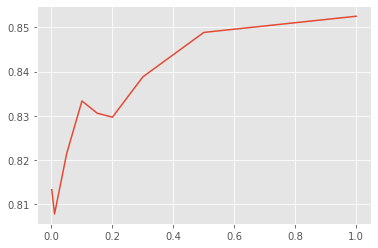

In [25]:
import matplotlib.pyplot as plt 
import seaborn as sns

plt.style.use('ggplot')
lr_results = pd.DataFrame(list(zip(learning_rate_values, results)), columns=['learning_rate', 'score'])
plt.plot(lr_results.learning_rate, lr_results.score);

In [26]:
# finetune n_estimators
import warnings

warnings.simplefilter('ignore')
n_estimator_values = [50, 100, 150, 200, 300, 400, 500, 600, 700, 800, 900, 1000]
results = []

for value in n_estimator_values:
    kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=2)
    xgb = XGBClassifier(booster='gbtree', learning_rate=0.3, n_estimators=value, max_depth=3, random_state=42, n_jobs=-1)
    scores = cross_val_score(xgb, X_resampled, y_resampled, cv=kfold)
    print('number estimators:', value, ', Score:', scores.mean())
    results.append(scores.mean())

pd.DataFrame(list(zip(n_estimator_values, results)), columns=['n_estimator', 'score'])

number estimators: 50 , Score: 0.831494396014944
number estimators: 100 , Score: 0.8351598173515982
number estimators: 150 , Score: 0.8406060606060606
number estimators: 200 , Score: 0.850626816106268
number estimators: 300 , Score: 0.8488003320880033
number estimators: 400 , Score: 0.8397011207970113
number estimators: 500 , Score: 0.8478995433789954
number estimators: 600 , Score: 0.8506309672063097
number estimators: 700 , Score: 0.8515442092154422
number estimators: 800 , Score: 0.8515442092154419
number estimators: 900 , Score: 0.8524574512245744
number estimators: 1000 , Score: 0.8515483603154836


,n_estimator,score
0,50,0.831494
1,100,0.835160
2,150,0.840606
3,200,0.850627
4,300,0.848800
5,400,0.839701
6,500,0.847900
7,600,0.850631
8,700,0.851544
9,800,0.851544


In [404]:
# finetune max_depth
import warnings

warnings.simplefilter('ignore')
max_depth_values = [1,2,3,4,5,6]
results = []

for value in max_depth_values:
    kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=2)
    xgb = XGBClassifier(booster='gbtree', learning_rate=0.2, n_estimators=200, max_depth=value, random_state=42, n_jobs=-1)
    scores = cross_val_score(xgb, X_resampled, y_resampled, cv=kfold)
    print('Max depth:', value, ', Score:', scores.mean())
    results.append(scores.mean())

pd.DataFrame(list(zip(max_depth_values, results)), columns=['max_depth', 'score'])

Max depth: 1 , Score: 0.8014653383146534
Max depth: 2 , Score: 0.8296720630967205
Max depth: 3 , Score: 0.8397135740971358
Max depth: 4 , Score: 0.8460813615608137
Max depth: 5 , Score: 0.8433333333333334
Max depth: 6 , Score: 0.8488044831880448


,max_depth,score
0,1,0.801465
1,2,0.829672
2,3,0.839714
3,4,0.846081
4,5,0.843333
5,6,0.848804


In [403]:
# finetune gamma
import warnings

warnings.simplefilter('ignore')
gamma_values = [0,1,2,3,4,5,6,7,8,9,10]
results = []

for value in gamma_values:
    kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=2)
    xgb = XGBClassifier(booster='gbtree', learning_rate=0.2, 
                                          n_estimators=200, 
                                          max_depth=3,
                                          gamma=value, 
                                          random_state=42, n_jobs=-1)
    scores = cross_val_score(xgb, X_resampled, y_resampled, cv=kfold)
    print('gamma:', value, ', Score:', scores.mean())
    results.append(scores.mean())

pd.DataFrame(list(zip(gamma_values, results)), columns=['gamma', 'score'])

gamma: 0 , Score: 0.8397135740971358
gamma: 1 , Score: 0.825134910751349
gamma: 2 , Score: 0.8132793690327936
gamma: 3 , Score: 0.8178497301784973
gamma: 4 , Score: 0.8178414279784143
gamma: 5 , Score: 0.8151266085512662
gamma: 6 , Score: 0.8151224574512245
gamma: 7 , Score: 0.8160273972602738
gamma: 8 , Score: 0.8096637608966375
gamma: 9 , Score: 0.8132959734329596
gamma: 10 , Score: 0.8087505188875053


,gamma,score
0,0,0.839714
1,1,0.825135
2,2,0.813279
3,3,0.817850
4,4,0.817841
5,5,0.815127
6,6,0.815122
7,7,0.816027
8,8,0.809664
9,9,0.813296


In [402]:
# finetune min_child_weight
import warnings

warnings.simplefilter('ignore')
min_child_weight_values = [0,1,2,3,4,5,6,7,8,9,10]
results = []

for value in min_child_weight_values:
    kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=2)
    xgb = XGBClassifier(booster='gbtree', learning_rate=0.2, 
                                          n_estimators=200, 
                                          max_depth=3,
                                          min_child_weight=value, 
                                          random_state=42, n_jobs=-1)
    scores = cross_val_score(xgb, X_resampled, y_resampled, cv=kfold)
    print('min_child_weight:', value, ', Score:', scores.mean())
    results.append(scores.mean())

pd.DataFrame(list(zip(min_child_weight_values, results)), columns=['min_child_weight', 'score'])

min_child_weight: 0 , Score: 0.8451764217517642
min_child_weight: 1 , Score: 0.8397135740971358
min_child_weight: 2 , Score: 0.8360481527604815
min_child_weight: 3 , Score: 0.8378787878787879
min_child_weight: 4 , Score: 0.8369696969696969
min_child_weight: 5 , Score: 0.8369863013698631
min_child_weight: 6 , Score: 0.8333374844333749
min_child_weight: 7 , Score: 0.8378829389788294
min_child_weight: 8 , Score: 0.8369738480697386
min_child_weight: 9 , Score: 0.8287588210875884
min_child_weight: 10 , Score: 0.8269406392694064


,min_child_weight,score
0,0,0.845176
1,1,0.839714
2,2,0.836048
3,3,0.837879
4,4,0.836970
5,5,0.836986
6,6,0.833337
7,7,0.837883
8,8,0.836974
9,9,0.828759


In [400]:
# finetune subsample
import warnings

warnings.simplefilter('ignore')
subsample_values = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.7, 0.8, 0.9, 1]
results = []

for value in subsample_values:
    kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=2)
    xgb = XGBClassifier(booster='gbtree', learning_rate=0.2, 
                                          n_estimators=200, 
                                          max_depth=3,
                                          min_child_weight=0,
                                          subsample=value, 
                                          random_state=42, n_jobs=-1)
    scores = cross_val_score(xgb, X_resampled, y_resampled, cv=kfold)
    print('subsample:', value, ', Score:', scores.mean())
    results.append(scores.mean())

pd.DataFrame(list(zip(subsample_values, results)), columns=['subsample', 'score'])

subsample: 0 , Score: 0.5
subsample: 0.1 , Score: 0.816928185969282
subsample: 0.2 , Score: 0.8442424242424243
subsample: 0.3 , Score: 0.836052303860523
subsample: 0.4 , Score: 0.8396720630967206
subsample: 0.5 , Score: 0.8433291822332919
subsample: 0.7 , Score: 0.8497052718970528
subsample: 0.8 , Score: 0.8551515151515151
subsample: 0.9 , Score: 0.8588044831880449
subsample: 1 , Score: 0.8451764217517642


,subsample,score
0,0.0,0.500000
1,0.1,0.816928
2,0.2,0.844242
3,0.3,0.836052
4,0.4,0.839672
5,0.5,0.843329
6,0.7,0.849705
7,0.8,0.855152
8,0.9,0.858804
9,1.0,0.845176


In [401]:
# finetune subsample
import warnings

warnings.simplefilter('ignore')
subsample_values = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.7, 0.8, 0.9, 1]
results = []

for value in subsample_values:
    kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=2)
    xgb = XGBClassifier(booster='gbtree', learning_rate=0.2, 
                                          n_estimators=200, 
                                          max_depth=3,
                                          min_child_weight=0,
                                          subsample=0.9, 
                                          random_state=42, n_jobs=-1)
    scores = cross_val_score(xgb, X_resampled, y_resampled, cv=kfold)
    print('subsample:', value, ', Score:', scores.mean())
    results.append(scores.mean())

pd.DataFrame(list(zip(subsample_values, results)), columns=['subsample', 'score'])

subsample: 0 , Score: 0.8588044831880449
subsample: 0.1 , Score: 0.8588044831880449
subsample: 0.2 , Score: 0.8588044831880449
subsample: 0.3 , Score: 0.8588044831880449
subsample: 0.4 , Score: 0.8588044831880449
subsample: 0.5 , Score: 0.8588044831880449
subsample: 0.7 , Score: 0.8588044831880449
subsample: 0.8 , Score: 0.8588044831880449
subsample: 0.9 , Score: 0.8588044831880449
subsample: 1 , Score: 0.8588044831880449


,subsample,score
0,0.0,0.858804
1,0.1,0.858804
2,0.2,0.858804
3,0.3,0.858804
4,0.4,0.858804
5,0.5,0.858804
6,0.7,0.858804
7,0.8,0.858804
8,0.9,0.858804
9,1.0,0.858804


# Gridsearch  
Continue with a gridsearch but  
* n_estimators = 200  
* learning_rate = 0.2  
* max_depth = 3  

In [289]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, StratifiedKFold, RepeatedStratifiedKFold

def grid_search(params, random=False): 
    
    xgb = XGBClassifier(booster='gbtree', objective='binary:logistic', random_state=42, use_label_encoder=False)
    
    kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    # kfold = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=2)
    
    if random:
        grid = RandomizedSearchCV(xgb, params, scoring='accuracy', cv=kfold, n_iter=20, n_jobs=-1, random_state=42)
    else:
        grid = GridSearchCV(xgb, params, scoring='accuracy', cv=kfold, n_jobs=-1)
    
    grid.fit(X_resampled, y_resampled)
    best_params = grid.best_params_
    print("Best params:", best_params)
    best_score = grid.best_score_
    print("Best score: {:.5f}".format(best_score))

    print(xgb)    

In [ ]:
grid_search(params={'learning_rate':[0.001, 0.01, 0.05, 0.1, 0.15, 0.2, 0.3, 0.5, 1.0],
                    'n_estimators':[50, 100, 150, 200, 300, 400, 500, 600, 700, 800, 900, 1000],
                    'max_depth':[1,2,3,4,5,6],
                    # 'min_child_weight':[3], 
                    # 'subsample':[.2, .4, .6, .8], 
                    # 'colsample_bytree':[0.9],
                    # 'colsample_bylevel':[0.6, 0.7, 0.8, 0.9, 1],
                    # 'colsample_bynode':[0.6, 0.7, 0.8, 0.9, 1]
                    })

In [399]:
# Best params: {'learning_rate': 0.2, 'max_depth': 6, 'n_estimators': 500}
# Best score: 0.86159
from sklearn.metrics import roc_auc_score, classification_report


xgb = XGBClassifier(base_score=None, booster='gbtree', colsample_bylevel=None,
                colsample_bynode=None, colsample_bytree=None,
                enable_categorical=False, gamma=None, gpu_id=None,
                importance_type=None, interaction_constraints=None,
                learning_rate=None, max_delta_step=None, max_depth=None,
                min_child_weight=None, monotone_constraints=None,
                n_estimators=100, n_jobs=None, num_parallel_tree=None,
                predictor=None, random_state=42, reg_alpha=None, reg_lambda=None,
                scale_pos_weight=None, subsample=None, tree_method=None,
                use_label_encoder=False, validate_parameters=None,
                verbosity=None)

kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scores = cross_val_score(xgb, X_resampled, y_resampled, cv=kfold, scoring='accuracy')
print('Accuracy: ', scores.round(4), )
print('Mean Accuracy: ', scores.mean().round(4))
print('')

xgb.fit(X_resampled, y_resampled)
y_pred_train = xgb.predict(X_resampled)
print('Accuracy: ', accuracy_score(y_resampled, y_pred_train))
print('ROC AUC: ', roc_auc_score(y_resampled, y_pred_train))
print(classification_report(y_resampled, y_pred_train))

kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scores = cross_val_score(xgb, X_resampled, y_resampled, cv=kfold, scoring='roc_auc')
print('ROC AUC: ', scores.round(4), )
print('Mean ROC AUC: ', scores.mean().round(4))

Accuracy:  [0.8409 0.8545 0.8409 0.8447 0.8813]
Mean Accuracy:  0.8525

Accuracy:  0.9735883424408015
ROC AUC:  0.9735883424408015
              precision    recall  f1-score   support

           0       0.97      0.98      0.97       549
           1       0.98      0.97      0.97       549

    accuracy                           0.97      1098
   macro avg       0.97      0.97      0.97      1098
weighted avg       0.97      0.97      0.97      1098

ROC AUC:  [0.8948 0.909  0.9067 0.93   0.9291]
Mean ROC AUC:  0.9139


In [390]:
# baseline
# xgb = XGBClassifier(booster='gbtree', objective='binary:logistic',, random_state=42)  
# xgb = XGBClassifier(booster='gbtree', learning_rate=0.02, n_estimators=200, max_depth=3, random_state=42)
# xgb = XGBRFClassifier(random_state=42)
# xgb = LogisticRegression(max_iter=1000, random_state=42)
# xgb = SVC(kernel= 'linear', random_state=42, C=0.1)  
# xgb = XGBClassifier(subsample=0.7, n_estimators=1000, max_depth= 3, learning_rate=0.3, gamma=4, colsample_bytree=0.7)p
# xgb = XGBClassifier(booster='gbtree', params=best_params, random_state=42)
# xgb = XGBClassifier(booster='gbtree', learning_rate=0.2, 
#                                           n_estimators=500, 
#                                           max_depth=6,
#                                           random_state=42, n_jobs=-1)
xgb = XGBClassifier(booster='gbtree', learning_rate=0.01, n_estimators=200, max_depth=3, random_state=42, verbosity=0)

# xgb.fit(X_train, y_train)
# xgb.fit(X_resampled, y_resampled)

kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=2)
scores = cross_val_score(xgb, X_resampled, y_resampled, cv=kfold)
xgb.fit(X_resampled, y_resampled)
print('Train Scores: ', scores)
print('Train STD: ', scores.std())
print('Train Score: ', scores.mean())

y_pred = xgb.predict(X_resampled)
print('X_train accuracy: {0:0.6f}'.format(accuracy_score(y_resampled, y_pred)))

y_pred = xgb.predict(X_test)
submission_csv = pd.concat([test_passengerids, pd.Series(y_pred)], axis=1)
submission_csv.columns = ['PassengerId', 'Survived']
submission_csv.to_csv(path/'submission.csv', index=False)
submission_csv.head()

Train Scores:  [0.81363636 0.79090909 0.82727273 0.78995434 0.84018265]
Train STD:  0.019800346878233472
Train Score:  0.8123910336239103
X_train accuracy: 0.824226


ValueError: Feature shape mismatch, expected: 7, got 12

In [263]:
print(xgb)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=-1,
              num_parallel_tree=1,
              params={'colsample_bylevel': 0.9, 'colsample_bynode': 0.6,
                      'colsample_bytree': 0.9, 'learning_rate': 0.2,
                      'max_depth': 3, 'min_child_weight': 3,
                      'n_estimators': 200, 'subsample': 0.4},
              predictor='auto', random_state=42, reg_alpha=0, reg_lambda=1,
              scale_pos_weight=1, subsample=1, tree_method='exact',
              validate_parameters=1, verbosity=None)


In [113]:
print(xgb)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=8,
              num_parallel_tree=1, predictor='auto', random_state=42,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)


In [11]:
import sweetviz as sv

my_report = sv.analyze(df_train, target_feat = 'Survived')
my_report.show_html() 

Done! Use 'show' commands to display/save.   |██████████| [100%]   00:00 -> (00:00 left)


Report SWEETVIZ_REPORT.html was generated! NOTEBOOK/COLAB USERS: the web browser MAY not pop up, regardless, the report IS saved in your notebook/colab files.


In [5]:
print('Imbalanced dataset?')
print(pd.DataFrame(Counter(df['Survived']), index=['survived']).transpose().sort_index())
df.isna().sum()

Imbalanced dataset?
   survived
0       549
1       342


PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [4]:
from sklearn.preprocessing import OneHotEncoder

categorical_columns = df.columns[df.dtypes==object].tolist()
numerical_columns = df.columns[df.dtypes!=object].tolist()

print('categorical: ', categorical_columns)
print('numerical: ', numerical_columns)

categorical:  ['Name', 'Sex', 'Ticket', 'Cabin', 'Embarked']
numerical:  ['PassengerId', 'Survived', 'Pclass', 'Age', 'SibSp', 'Parch', 'Fare']


### Convert `Pclass` from numeric to categorical

In [5]:
df['Pclass'].replace((1,2,3), ("1", "2", "3"), inplace=True)
categorical_columns = df.columns[df.dtypes==object].tolist()
numerical_columns = df.columns[df.dtypes!=object].tolist()

print('categorical: ', categorical_columns)
print('numerical: ', numerical_columns)

categorical:  ['Pclass', 'Name', 'Sex', 'Ticket', 'Cabin', 'Embarked']
numerical:  ['PassengerId', 'Survived', 'Age', 'SibSp', 'Parch', 'Fare']


### Let's build the model

In [102]:
import re

def get_title(name):
    pattern = ',\s.*\.\s'
    match_results = re.search(pattern, name)
    result = match_results.group()[2:-2]
    if result not in ['Mr', 'Miss', 'Mrs', 'Master', 'Dr', 'Rev']:
        result = 'Other'
    return result

# Load data

In [104]:
df = pd.read_csv(path/'train.csv')
df = df.sample(frac=1, random_state=42)
X = df.iloc[:, 2:]
y = df.iloc[:, 1]

In [107]:
from sklearn.base import TransformerMixin

class CustomPreprossessing(TransformerMixin):
    def __init__(self):
        None
    def fit(self, X, y=None):
        return self
    def transform(self, X, y=None):
        # my custom code
        X['title'] = X.apply(lambda x: get_title(x['Name']), axis=1)
        X['Cabin'].fillna('Empty', inplace=True)
        # X['cab'] = [i if i in ['A', 'B', 'C', 'D', 'E', 'F'] else 'Other' for i in X['Cabin'].str[:1]]
        X = X.loc[:, ~X.columns.isin(['Name', 'Ticket', 'Cabin'])]
        return X      

In [142]:
TRAIN_SIZE
df[0:TRAIN_SIZE]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
709,710,1,3,"Moubarek, Master. Halim Gonios (""William George"")",male,NaN,1,1,2661,15.2458,NaN,C
439,440,0,2,"Kvillner, Mr. Johan Henrik Johannesson",male,31.00,0,0,C.A. 18723,10.5000,NaN,S
840,841,0,3,"Alhomaki, Mr. Ilmari Rudolf",male,20.00,0,0,SOTON/O2 3101287,7.9250,NaN,S
720,721,1,2,"Harper, Miss. Annie Jessie ""Nina""",female,6.00,0,1,248727,33.0000,NaN,S
39,40,1,3,"Nicola-Yarred, Miss. Jamila",female,14.00,1,0,2651,11.2417,NaN,C
...,...,...,...,...,...,...,...,...,...,...,...,...
505,506,0,1,"Penasco y Castellana, Mr. Victor de Satode",male,18.00,1,0,PC 17758,108.9000,C65,C
639,640,0,3,"Thorneycroft, Mr. Percival",male,NaN,1,0,376564,16.1000,NaN,S
878,879,0,3,"Laleff, Mr. Kristo",male,NaN,0,0,349217,7.8958,NaN,S
824,825,0,3,"Panula, Master. Urho Abraham",male,2.00,4,1,3101295,39.6875,NaN,S


In [9]:
df = pd.read_csv(path/'train.csv')
df["kfold"] = -1

df = df.sample(frac=1).reset_index(drop=True)

kf = model_selection.StratifiedKFold(n_splits=5, shuffle=False)
df.tail()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,kfold
886,547,1,2,"Beane, Mrs. Edward (Ethel Clarke)",female,19.0,1,0,2908,26.0000,NaN,S,-1
887,332,0,1,"Partner, Mr. Austen",male,45.5,0,0,113043,28.5000,C124,S,-1
888,399,0,2,"Pain, Dr. Alfred",male,23.0,0,0,244278,10.5000,NaN,S,-1
889,871,0,3,"Balkic, Mr. Cerin",male,26.0,0,0,349248,7.8958,NaN,S,-1
890,226,0,3,"Berglund, Mr. Karl Ivar Sven",male,22.0,0,0,PP 4348,9.3500,NaN,S,-1


In [8]:
# custom encoder for dummies
from sklearn import preprocessing
import os
import pandas as pd
from sklearn import ensemble
from sklearn import preprocessing
from sklearn import model_selection
from sklearn import metrics
import joblib

# from . import dispatcher

df = pd.read_csv(path/'train.csv')
df["kfold"] = -1

df = df.sample(frac=1).reset_index(drop=True)

kf = model_selection.StratifiedKFold(n_splits=5, shuffle=False)     #, random_state=42)

df.head()
for fold, (train_idx, val_idx) in enumerate(kf.split(X=df, y=df.target.values)):
    print(len(train_idx), len(val_idx))
    df.loc[val_idx, 'kfold'] = fold

# df.to_csv(path/'train_folds.csv', index=False)

AttributeError: 'DataFrame' object has no attribute 'target'

In [108]:
from sklearn.base import TransformerMixin 

class NullValueImputer(TransformerMixin):
    def __init__(self):
        None
    def fit(self, X, y=None):
        return self
    def transform(self, X, y=None):
        for column in X.columns.tolist():
            if column in X.columns[X.dtypes==object].tolist():
                X[column] = X[column].fillna(X[column].mode()[0])     # omd: should I change to: .mode()[0] ?
            else:
                X[column]=X[column].fillna(-999.0)
        return X

In [109]:
import numpy as np
import pandas as pd

from sklearn.base import BaseEstimator, TransformerMixin

class TargetEncode(BaseEstimator, TransformerMixin):
    
    def __init__(self, categories='auto', k=1, f=1, 
                 noise_level=0, random_state=None):
        if type(categories)==str and categories!='auto':
            self.categories = [categories]
        else:
            self.categories = categories
        self.k = k
        self.f = f
        self.noise_level = noise_level
        self.encodings = dict()
        self.prior = None
        self.random_state = random_state
        
    def add_noise(self, series, noise_level):
        return series * (1 + noise_level *   
                         np.random.randn(len(series)))
        
    def fit(self, X, y=None):
        if type(self.categories)=='auto':
            self.categories = np.where(X.dtypes == type(object()))[0]
        
        temp = X.loc[:, self.categories].copy()
        temp['target'] = y
        self.prior = np.mean(y)
        for variable in self.categories:
            avg = (temp.groupby(by=variable)['target']
                       .agg(['mean', 'count']))
            # Compute smoothing 
            smoothing = (1 / (1 + np.exp(-(avg['count'] - self.k) /                 
                         self.f)))
            # The bigger the count the less full_avg is accounted
            self.encodings[variable] = dict(self.prior * (1 -  
                             smoothing) + avg['mean'] * smoothing)
            
        return self
    
    def transform(self, X):
        Xt = X.copy()
        for variable in self.categories:
            Xt[variable].replace(self.encodings[variable], 
                                 inplace=True)
            unknown_value = {value:self.prior for value in 
                             X[variable].unique() 
                             if value not in 
                             self.encodings[variable].keys()}
            if len(unknown_value) > 0:
                Xt[variable].replace(unknown_value, inplace=True)
            Xt[variable] = Xt[variable].astype(float)
            if self.noise_level > 0:
                if self.random_state is not None:
                    np.random.seed(self.random_state)
                Xt[variable] = self.add_noise(Xt[variable], 
                                              self.noise_level)
        return Xt
    
    def fit_transform(self, X, y=None):
        self.fit(X, y)
        return self.transform(X)


In [110]:
from scipy.sparse import csr_matrix
from scipy.sparse import hstack

class SparseMatrix(TransformerMixin):
    def __init__(self):
        None
    def fit(self, X, y=None):
        return self
    def transform(self, X, y=None):
        categorical_columns= X.columns[X.dtypes==object].tolist()
        ohe = OneHotEncoder(handle_unknown='ignore')               # omd: may need to change later
        # ohe = OneHotEncoder() 
        hot = ohe.fit_transform(X[categorical_columns])
        cold_df = X.select_dtypes(exclude=["object"])
        cold = csr_matrix(cold_df)
        final_sparse_matrix = hstack((hot, cold))
        final_csr_matrix = final_sparse_matrix.tocsr()
        return final_csr_matrix

In [111]:
from sklearn.model_selection import cross_val_score, KFold, train_test_split
from xgboost import XGBClassifier
from sklearn.pipeline import Pipeline

In [112]:
from sklearn.pipeline import Pipeline

kfold = KFold(n_splits=5, shuffle=True, random_state=2)
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=2)

data_pipeline = Pipeline([('custom_prepross', CustomPreprossessing()), ('null_imputer', NullValueImputer()), ('sparse', SparseMatrix())])
X_train_transformed = data_pipeline.fit_transform(X_train)
X_test_transformed = data_pipeline.fit_transform(X_test)

In [113]:
def cross_val(model):
    # roc_scores = cross_val_score(model, X_train_transformed, y_train, scoring='roc_auc', cv=kfold)
    # roc = (roc_scores.mean())
    accuracy_scores = cross_val_score(model, X_train_transformed, y_train, scoring='accuracy', cv=kfold)
    acc = (accuracy_scores.mean())
    print(model)
    
    return acc

# Baseline

In [114]:
cross_val(XGBClassifier(missing=-999.0))

[10:53:24] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[10:53:25] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[10:53:25] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[10:53:25] WARNING: /Users/runner/miniforge3/cond

0.8008753226349455

In [89]:
# booster='gblinear'
full_pipeline = Pipeline([('custom_prepross', CustomPreprossessing()),
                          ('null_imputer', NullValueImputer()), 
                          ('sparse', SparseMatrix()), 
                          ('xgb', XGBClassifier(booster='gblinear', missing=-999.0))])
full_pipeline.fit(X_train, y_train)

[19:20:44] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


Pipeline(steps=[('custom_prepross',
                 <__main__.CustomPreprossessing object at 0x7f95c819e670>),
                ('null_imputer',
                 <__main__.NullValueImputer object at 0x7f95c819ef70>),
                ('sparse', <__main__.SparseMatrix object at 0x7f95c819e6d0>),
                ('xgb',
                 XGBClassifier(base_score=0.5, booster='gblinear',
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=None, enable_categor...
                               gamma=None, gpu_id=-1, importance_type=None,
                               interaction_constraints=None, learning_rate=0.5,
                               max_delta_step=None, max_depth=None,
                               min_child_weight=None, missing=-999.0,
                               monotone_constraints=None, n_estimators=100,
                               n_jobs=8, num_parallel_tree=None, predictor=None,
                               random_state=0, reg_alpha=0, reg_lambda=0,
                               scale_pos_weight=1, subsample=None,
                               tree_method=None, validate_parameters=1,
                               verbosity=None))])

In [130]:
# random forest
from xgboost import XGBRFClassifier

full_pipeline = Pipeline([('custom_prepross', CustomPreprossessing()),
                          ('null_imputer', NullValueImputer()), 
                          ('sparse', SparseMatrix()), 
                          ('xgb', XGBRFClassifier(n_estimators=80, missing=-999.0))])
full_pipeline.fit(X_train, y_train)

[11:19:17] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


Pipeline(steps=[('custom_prepross',
                 <__main__.CustomPreprossessing object at 0x7f95c9b9ed60>),
                ('null_imputer',
                 <__main__.NullValueImputer object at 0x7f95ea36d460>),
                ('sparse', <__main__.SparseMatrix object at 0x7f95ea36d400>),
                ('xgb',
                 XGBRFClassifier(base_score=0.5, booster='gbtree',
                                 colsample_bylevel=1, colsample_bytree=1,
                                 enable_categorical=False, gamma=0, gpu_id=-1,
                                 importance_type=None,
                                 interaction_constraints='', max_delta_step=0,
                                 max_depth=6, min_child_weight=1,
                                 missing=-999.0, monotone_constraints='()',
                                 n_estimators=80, n_jobs=8,
                                 num_parallel_tree=80,
                                 objective='binary:logistic', predictor='auto',
                                 random_state=0, reg_alpha=0,
                                 scale_pos_weight=1, tree_method='exact',
                                 validate_parameters=1, verbosity=None))])

In [74]:
# booster='dart'
full_pipeline = Pipeline([('custom_prepross', CustomPreprossessing()),
                          ('null_imputer', NullValueImputer()), 
                          ('sparse', SparseMatrix()), 
                          ('xgb', XGBClassifier(booster='dart', one_drop=True, missing=-999.0))])
full_pipeline.fit(X_train, y_train)

[18:47:58] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


Pipeline(steps=[('custom_prepross',
                 <__main__.CustomPreprossessing object at 0x7f95fbe31bb0>),
                ('null_imputer',
                 <__main__.NullValueImputer object at 0x7f95fbe311c0>),
                ('sparse', <__main__.SparseMatrix object at 0x7f95fbe318e0>),
                ('xgb',
                 XGBClassifier(base_score=0.5, booster='dart',
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytree=1, enable_categorical=False,
                               ga...
                               interaction_constraints='',
                               learning_rate=0.300000012, max_delta_step=0,
                               max_depth=6, min_child_weight=1, missing=-999.0,
                               monotone_constraints='()', n_estimators=100,
                               n_jobs=8, num_parallel_tree=1, one_drop=True,
                               predictor='auto', random_state=0, reg_alpha=0,
                               reg_lambda=1, scale_pos_weight=1, subsample=1,
                               tree_method='exact', validate_parameters=1,
                               verbosity=None))])

In [119]:
# params = {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 300}     # from GridSearch below
# params = {'subsample': 1, 'n_estimators': 200, 'min_child_weight': 3, 'max_depth': 5, 'learning_rate': 0.1, 'colsample_bytree': 0.7, 'colsample_bynode': 0.8}
params = {'colsample_bytree': 0.5, 'gamma': 0.5, 'learning_rate': 0.01, 'max_depth': 6, 'min_child_weight': 1, 'n_estimators': 100, 'scale_pos_weight': 1, 'subsample': 1}
full_pipeline = Pipeline([('custom_prepross', CustomPreprossessing()),
                          ('null_imputer', NullValueImputer()), 
                          ('sparse', SparseMatrix()), 
                          ('xgb', XGBClassifier(params=params, missing=-999.0))])
full_pipeline.fit(X_train, y_train)
# print(XGBClassifier(params=params, missing=-999.0))

[11:00:24] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:576: 
Parameters: { "params" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[11:00:24] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


Pipeline(steps=[('custom_prepross',
                 <__main__.CustomPreprossessing object at 0x7f95c9b8f430>),
                ('null_imputer',
                 <__main__.NullValueImputer object at 0x7f95c9b8ff40>),
                ('sparse', <__main__.SparseMatrix object at 0x7f95c9b8f1f0>),
                ('xgb',
                 XGBClassifier(base_score=0.5, booster='gbtree',
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytree=1, enable_categorical=False,...
                               monotone_constraints='()', n_estimators=100,
                               n_jobs=8, num_parallel_tree=1,
                               params={'colsample_bytree': 0.5, 'gamma': 0.5,
                                       'learning_rate': 0.01, 'max_depth': 6,
                                       'min_child_weight': 1,
                                       'n_estimators': 100,
                                       'scale_pos_weight': 1, 'subsample': 1},
                               predictor='auto', random_state=0, reg_alpha=0,
                               reg_lambda=1, scale_pos_weight=1, subsample=1,
                               tree_method='exact', validate_parameters=1,
                               verbosity=None))])

In [131]:
from sklearn.metrics import accuracy_score 

y_pred = full_pipeline.predict(X_train)
print('Train accuracy: {0:0.6f}'.format(accuracy_score(y_train, y_pred)))
y_pred = full_pipeline.predict(X_test)
print('Test accuracy: {0:0.6f}'.format(accuracy_score(y_test, y_pred)))

Train accuracy: 0.884731
Test accuracy: 0.834081


### Score 'Hold-Out' Test dataset

| Kaggle score | hyperparameters | Accuracy Score |  Date  |
|----------|---------------- |--------|---------|
| 0.72966  |  'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 300 | train: 0.83388  test: 0.8116591928251121 | Jul 17, 2022 |
| 0.72966  |  'subsample': 1, 'n_estimators': 200, 'min_child_weight': 3, 'max_depth': 5, 'learning_rate': 0.1, 'colsample_bytree': 0.7, 'colsample_bynode': 0.8 | train: 0.83238 test: 0.8116591928251121 | Jul 17, 2022 |
| 0.73684  |  booster='dart', one_drop=True | train: 0.979042  test: 0.802691 | Jul 17, 2022 |
| 0.77272  |  XGBRFClassifier | train: 0.886228  test: 0.829596 | Jul 17, 2022 |
|  0.75358 | XGBClassifier(booster='gblinear') | train: 0.835329  test: 0.807175  | Jul 17, 2022 |



In [132]:
df_holdout = pd.read_csv(path/'test.csv')
X_holdout = df_holdout.iloc[:, 1:]
y_holdout = full_pipeline.predict(X_holdout)
df_submission = df_holdout[['PassengerId']]
df_submission['Survived'] = y_holdout.tolist()
print(df_submission.head())
df_submission.to_csv(path/'submission.csv', index=False)

   PassengerId  Survived
0          892         0
1          893         0
2          894         0
3          895         0
4          896         1


---

### GridSearch

In [ ]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, StratifiedKFold, RepeatedStratifiedKFold

def grid_search(params, random=False): 
    
    xgb = XGBClassifier(booster='gbtree', objective='binary:logistic', random_state=42, use_label_encoder=False)
    
    kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=2)
    # kfold = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=2)
    
    if random:
        grid = RandomizedSearchCV(xgb, params, scoring='accuracy', cv=kfold, n_iter=20, n_jobs=-1, random_state=2)
    else:
        grid = GridSearchCV(xgb, params, scoring='accuracy', cv=kfold, n_jobs=-1)
    
    grid.fit(X_train_transformed, y_train)
    best_params = grid.best_params_
    print("Best params:", best_params)
    best_score = grid.best_score_
    print("Best score: {:.5f}".format(best_score))

    print(xgb)

    xgb = XGBClassifier(booster='gbtree', objective='binary:logistic', 
                        random_state=2, use_label_encoder=False, 
                        params=best_params, missing=-999.0)
    print(xgb)
    xgb.fit(X_train_transformed, y_train)
    y_pred = xgb.predict(X_test_transformed)
    print('Test score: {0:0.8f}'.format(accuracy_score(y_pred, y_test)))

In [122]:
# Best params: {'colsample_bytree': 0.5, 'gamma': 0.5, 'learning_rate': 0.01, 'max_depth': 6, 'min_child_weight': 1, 'n_estimators': 100, 'scale_pos_weight': 1, 'subsample': 1}
# Best score: 0.83076
# Test score: 0.84304933

Best params: {'colsample_bytree': 0.5, 'gamma': 0.5, 'learning_rate': 0.01, 'max_depth': 6, 'min_child_weight': 1, 'n_estimators': 100, 'scale_pos_weight': 1, 'subsample': 1}
Best score: 0.83076

grid_search(params={'learning_rate':[0.01, 0.05, 0.1, 0.2, 0.3],
                    'n_estimators':[100, 200, 300],
                    'scale_pos_weight':[1],
                    'max_depth':[6],
                    'gamma':[0.5], # Best score: 0.83532     #Test score: 0.81165919
                    'min_child_weight':[1],  # Best score: 0.83532   # Test score: 0.81165919
                    'subsample':[1],
                    'colsample_bytree':[0.5, 0.7, 0.8, 0.9, 1]
                    },
            random=False)

[11:09:46] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[11:09:48] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[11:09:48] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[11:09:49] WARNING: /Users/runner/miniforge3/cond

/Users/oliverdreger/opt/anaconda3/envs/dcr/lib/python3.8/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/Users/oliverdreger/opt/anaconda3/envs/dcr/lib/python3.8/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/Users/oliverdreger/opt/anaconda3/envs/dcr/lib/python3.8/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/Users/oliverdreger/opt/anaconda3/envs/dcr/lib/python3.8/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is d

[11:09:50] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[11:09:50] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[11:09:50] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[11:09:50] WARNING: /Users/runner/miniforge3/cond

--- 

### What if test dataset has additional categories for a variable?  
[Regular Expressions in Python](http://chris35wills.github.io/courses/Intermediate_python/regexp/) 

In [336]:
df_train = pd.read_csv(path/'train.csv')
df_test = pd.read_csv(path/'test.csv')
X_train = df_train.drop(['Survived'], axis=1)
X_test = df_test.copy()
df = pd.concat([X_train, X_test], axis=0)
combine = [X_train, X_test]
df_train.head(10)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
5,6,0,3,"Moran, Mr. James",male,NaN,0,0,330877,8.4583,NaN,Q
6,7,0,1,"McCarthy, Mr. Timothy J",male,54.0,0,0,17463,51.8625,E46,S
7,8,0,3,"Palsson, Master. Gosta Leonard",male,2.0,3,1,349909,21.0750,NaN,S
8,9,1,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,27.0,0,2,347742,11.1333,NaN,S
9,10,1,2,"Nasser, Mrs. Nicholas (Adele Achem)",female,14.0,1,0,237736,30.0708,NaN,C


In [324]:
df.isna().sum()

PassengerId       0
Pclass            0
Name              0
Sex               0
Age             263
SibSp             0
Parch             0
Ticket            0
Fare              1
Cabin          1014
Embarked          2
dtype: int64

In [350]:
import re

def get_title(name):
    pattern = ',\s.*\.\s'
    match_results = re.search(pattern, name)
    result = match_results.group()[2:-2]
    if result not in ['Mr', 'Miss', 'Mrs', 'Master', 'Dr', 'Rev']:
        result = 'Other'
    return result

In [351]:
df['title'] = df.apply(lambda x: get_title(x['Name']), axis=1)

In [352]:
df.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,title
0,1,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,Mr
1,2,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,Mrs
2,3,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,Miss
3,4,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,Mrs
4,5,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,Mr


In [353]:
df['title'].value_counts()

Mr        757
Miss      260
Mrs       196
Master     61
Other      19
Rev         8
Dr          8
Name: title, dtype: int64

source: [kaggle.com](https://www.kaggle.com/code/omd123/titanic-data-science-solutions)

In [385]:
txt = 'Braund, Mr. Owen Harris'
re.search('Owen', txt)

if re.search('Owen', txt):
    print('match found')
else:
    print('no match found')

match found


In [386]:
xgb

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=8,
              num_parallel_tree=1, predictor='auto', random_state=42,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', use_label_encoder=False,
              validate_parameters=1, verbosity=None)

In [383]:
df['Title'] = df['Name'].str.extract(' ([A-Za-z]+)\.', expand=False)

# pd.crosstab(df['Title'], df['Sex'])
print('Can values be combined?')
pd.concat([X_train, df_train['Survived']], axis=1).groupby(['Title'])['Survived'].agg(
    ['mean', 'count']).sort_values(by=['mean'], ascending=False)

# Sir, Countess

Can values be combined?


,mean,count
Title,,
Sir,1.000000,1
Countess,1.000000,1
Ms,1.000000,1
Mme,1.000000,1
Lady,1.000000,1
Mlle,1.000000,2
Mrs,0.792000,125
Miss,0.697802,182
Master,0.575000,40


In [348]:
for dataset in combine:
    dataset['Title'] = dataset.Name.str.extract(' ([A-Za-z]+)\.', expand=False)

pd.crosstab(X_train['Title'], X_train['Sex'])

Sex,female,male
Title,,
Capt,0,1
Col,0,2
Countess,1,0
Don,0,1
Dr,1,6
Jonkheer,0,1
Lady,1,0
Major,0,2
Master,0,40
